# Linear Regression with Stochastic Gradient Descent on batch size 'm'

Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import random as r

%matplotlib inline

In [ ]:
def extractRows(x, y, size):
    """
    Randomly chooses a set of rows whose count is
    specified by the size parameter and returns it
    to the caller.
    
    Parameters
    ----------
    x : Nxd matrix
        where N is the number of input data points
        and d is the number of dimensions
        Input data points stored in the form of
        a NumPy matrix
    y : Nx1 matrix
        Actual outputs observed for the input
        data points
    size : Integer
        The number of rows to be returned
    
    Returns
    -------
    size x d matrix
        which contains randomly selected data
        points in the form of a matrix        
    size x 1 matrix
        which contains the outpus for randomly
        selected points in the form of a matrix
    """
    
    # Generate a random list of integers between
    # 0 and N whose count is specified by 'size'
    row_indices = r.sample(range(0, x.shape[0]), size)
    
    # Extract the rows whose indices are equal
    # to the members of above list
    return x[row_indices], y[row_indices]

Define the function to compute prediction error

In [ ]:
def computeError(x, y, theta):
    """
    Calculates the cost function J and returns it
    to the caller.
    
    Parameters
    ----------
    x : Nxd matrix
        N is number of samples and d is number of params
    y : Nx1 matrix
        The matrix storing the actual outputs
    theta: 1xd matrix
        The matrix storing regression parameters
    
    Returns
    -------
    Nx1 matrix
        Matrix storing prediction error for each input
        data point
    """
    return (x * theta.T - y)

Define a function to compute RSS

In [4]:
def computeCost(error):
    """
    Calculates the overall cost and returns it
    to the caller.
    
    Parameters
    ----------
    error : Nx1 matrix
        Matrix storing prediction error for each
        input data point where N is the number of
        input data points
    
    Returns
    -------
    float
        Overall cost for the current step calculated
        as (sum of squared error) / (2 * N)
    """
    inner = np.power(error, 2)
    return np.sum(inner) / (2 * len(error))

Define the method to perform stochastic gradient descent

In [5]:
def generate_folds(X, k, randomize = False):
    """
    Generates k (training, validation) pairs from
    the given data
    
    Parameters
    ----------
    X : Nxd matrix
        where N is the total number of input data
        points and d is the number of features
    k : Integer
        Number of folds to be generated
    randomize : boolean
        True iff data must be shuffled before
        being split into (training, validation)
        pairs
    
    Yields
    ------
    k (training, validation) pairs
    """
    
    # Shuffle the data if necessary    
    if randomize:
        X = list(X)
        r.shuffle(X)
    
    for i in range(k):
        training = [x for j, x in enumerate(X, start = 1) if j % k != i]
        validation = [x for j, x in enumerate(X, start = 1) if j % k == i]
        yield training, validation

In [6]:
def do_k_fold_CV(data, result_col_name, theta, alpha, iterations, batch_size, l2_penality_values, K):
    
    # For each value of L2 penality, compute
    # the average MSE after fitting a model
    # for each fold
    l2_penality_mse = np.zeros(len(l2_penality_values))
    
    # Define variables to track the min MSE
    # and best L2 penality
    min_mse = None
    best_l2_penality = None
    
    # Split the data headers into X and Y
    
    
    # Create as many folds as needed for cross
    # validation and run linear regression on
    # each training-validation pair
    for training, validation in generate_folds(data.values, K, True):
        # Convert the splits into dataframe
        data_cols = list(data.columns.values)
        t_df = pd.DataFrame(training, columns=data_cols)
        v_df = pd.DataFrame(validation, columns=data_cols)
        
        # Split the datasets into X and Y
        data_cols.remove(result_col_name)
        t_X = t_df[data_cols]
        t_Y = t_df[[result_col_name]]
        v_X = v_df[data_cols]
        v_Y = v_df[[result_col_name]]
        
        # Convert X and Y into matrices
        t_X = np.matrix(t_X.values)
        t_Y = np.matrix(t_Y.values)
        v_X = np.matrix(v_X.values)
        v_Y = np.matrix(v_Y.values)
        
        for i, l2_penality in enumerate(l2_penality_values):
            # Initialize theta
            t_theta, error, cost = performSGD(t_X, t_Y, theta, alpha, iterations, batch_size, l2_penality)
            # Predict validation set outputs
            v_Y_prediction = v_X * t_theta.T
            #print("v_Y_prediction: ", v_Y_prediction.shape)
            v_l1_error = v_Y_prediction - v_Y
            #print("v_l1_error: ", v_l1_error.shape)
            v_l2_error = v_l1_error.T * v_l1_error
            #print("v_l2_error: ", v_l2_error.shape)
            l2_penality_mse[i] += v_l2_error.sum()
    
    l2_penality_mse = l2_penality_mse / K
    
    # Find the min mse and corresponding l2 penality
    min_mse = None
    best_l2_penality = None
    
    for i, val in enumerate(l2_penality_mse):
        if min_mse is None or val < min_mse:
            min_mse = val
            best_l2_penality = l2_penality_values[i]            
    
    return l2_penality_mse, best_l2_penality

In [7]:
def performSGD(x, y, theta, alpha, iterations, batch_size, l2_penality):
    """
    Performs stochastic gradient descent logic on
    the matrices passed as arguments and returns the
    regression parameters in the form of a column
    matrix along with the overall cost involved.
    
    Parameters
    ----------
    x : Nxd matrix
        The matrix storing the values for selected 
        features
    y : Nx1 matrix
        The matrix storing the actual output values
    theta: Nx1 matrix
        The column vector storing the regression 
        parameters
    alpha: float
        The learning rate or the step size
    iterations: integer
        The number of iterations to be done
    batch_size : Integer
        Number of rows to consider in each iteration
    l2_penality : Double
        The L2 penality to be applied
    
    Returns
    -------
    theta: Nx1 matrix
        The column vector storing the new regression 
        parameters
    """
    # Initialize a new column vector to store the
    # new regression paramters calculated in this
    # step
    theta_new = np.matrix(np.zeros(theta.shape))
    
    # Extract feature count from theta
    param_count = theta.ravel().shape[1]
    
    # Initialize variables to store the cost at
    # each iteration
    cost = np.zeros(iterations)
    
    # Gradient descent logic
    for i in range(iterations):
        # Sample the data for this iteration
        x_sample, y_sample = extractRows(x, y, batch_size)
        
        # Calculate the residual using the formula
        # (x * theta.T - y)
        error = computeError(x_sample, y_sample, theta)
        
        # Calculate the learning rate for this 
        # iteration
        effective_alpha = (alpha / i) if (i > 0) else alpha
        
        # Process each feature vector
        for j in range(param_count):
            # Multiple the current feature vector 
            # with error
            term = np.multiply(error, x_sample[:, j])
            
            # Calculate the new values for theta            
            theta_new[0, j] = (1 - 2 * effective_alpha * l2_penality) * theta[0, j] - (effective_alpha / len(x_sample)) * np.sum(term)
        
        # Update theta with new values
        theta = theta_new
        
        # Calculate the overall RSS for this iteration        
        cost[i] = computeCost(error)
        
    return theta, error, cost

## Data Setup

In [12]:
def add_polynomial_cols(data, degree, result_col_name):
    """
    Generate polynomial columns for all
    columns in the data based on the
    specified degree.
    
    Parameters
    ----------
    data : Pandas DataFrame
        The data to be manipulated
    degree : Integer
        The polynomial degree
    result_col_name : String
        The name of the column that stores
        the results
    
    Returns
    -------
    Pandas DataFrame
        storing the updated data
    """
    # Fetch the list of column names
    cols = list(data.columns.values)
    
    # Create polynomial columns for all
    # except the result column
    for col in cols:
        if (col != result_col_name):
            for i in range(degree + 1):
                if (i != 1):
                    new_col_name = col + str(i)
                    data[new_col_name] = data[col].apply(lambda x: pow(x, i))
        
    return data

def pre_process(data, result_col_name, degree):
    # Add polynomial columns
    data = add_polynomial_cols(data, degree, result_col_name)
    
    # Split data and result columns into
    # X and Y
    data_cols = list(data.columns.values)
    data_cols.remove(result_col_name)
    
    X = data[data_cols]
    X = np.matrix(X.values)
    
    Y = data[[result_col_name]]
    Y = np.matrix(Y.values)
    
    return data, X, Y

def load_train_data(path):
    train_data = sio.loadmat(path)
    train_data = pd.DataFrame(np.hstack((train_data['X_trn'], train_data['Y_trn'])))
    train_data.columns = ['X_trn', 'Y_trn']
    return train_data

def plot_training_data_fit(train_data, degree, theta):
    x = np.linspace(train_data.X_trn.min(), train_data.X_trn.max(), 100)

    f = 0
    for i in range(degree + 1):
        f += (theta[0, i] * pow(x, i))

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(train_data.X_trn, train_data.Y_trn, label='Traning Data')
    ax.legend(loc=2)
    ax.set_xlabel('X_trn')
    ax.set_ylabel('Y_trn')
    ax.set_title('Predicted X_trn vs. Y_trn')

def generate_model(path, result_col_name, theta, degree, alpha, iterations, batch_size, folds = None):
    train_data = load_train_data(path)
    train_data, X, Y = pre_process(train_data, result_col_name, degree)
    
    if folds is None:
        folds = X.shape[0]
    
    # K-fold CV
    l2_penality_values = np.logspace(-4, 10, num=10)
    l2_penality_mse, best_l2_penality = do_k_fold_CV(train_data, result_col_name, theta, alpha, iterations, batch_size, l2_penality_values, folds)
    print("L2 Penality MSEs: ", l2_penality_mse)
    print("Best L2 penality value: ", best_l2_penality)
    
    plot_cv_error(l2_penality_values, l2_penality_mse)
    
    theta, error, cost = performSGD(X, Y, theta, alpha, iterations, batch_size, best_l2_penality)
    print("Theta: ", theta)
    print("Regression error: ", error.sum())
    print("Train error: ", cost.sum())
    
    plot_training_data_fit(train_data, degree, theta)
    
    return theta

def load_test_data(path):
    test_data = sio.loadmat(path)
    test_data = pd.DataFrame(np.hstack((test_data['X_tst'], test_data['Y_tst'])))
    test_data.columns = ['X_tst', 'Y_tst']
    return test_data

def plot_test_data_fit(test_data, degree, theta):
    x = np.linspace(test_data.X_tst.min(), test_data.X_tst.max(), 100)

    f = 0
    for i in range(degree + 1):
        f += (theta[0, i] * pow(x, i))

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(test_data.X_tst, test_data.Y_tst, label='Test Data')
    ax.legend(loc=2)
    ax.set_xlabel('X_tst')
    ax.set_ylabel('Y_tst')
    ax.set_title('Predicted X_tst vs. Y_tst')

def plot_cv_error(l2_penality_values, l2_penality_mse):
    plt.plot(l2_penality_values, l2_penality_mse, 'k-')
    plt.xlabel('$\ell_2$ penalty')
    plt.ylabel('K-fold cross validation error')
    plt.xscale('log')
    plt.yscale('log')

def predict(path, result_col_name, degree, theta):
    test_data = load_test_data(path)
    test_data, X, Y = pre_process(test_data, result_col_name, degree)
    
    error = computeError(X, Y, theta)
    print("Regression error: ", error.sum())
    
    cost = computeCost(error)
    print("Test error: ", cost.sum())
    
    plot_test_data_fit(test_data, degree, theta)

L2 Penality MSEs:  [ 2797.69850575  2792.45891262  2936.36031365  2777.53546236  2873.81145181
  2801.11997167  2849.58615265  2937.57396625  3986.06364837  4681.57243812]
Best L2 penality value:  4.64158883361
Theta:  [[  1.26332194e-06   8.89050453e-08  -1.05207274e-06   5.14460949e-05
   -1.67767462e-04   2.45927863e-03]]
Regression error:  -58.6888796105
Train error:  138856.514489
Regression error:  -618.182551467
Test error:  4523.80419629


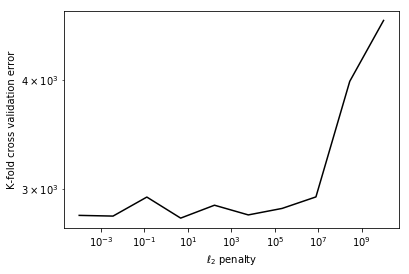

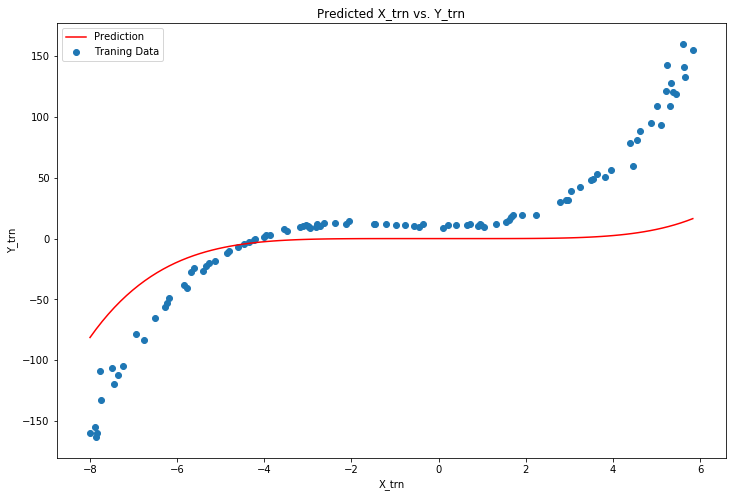

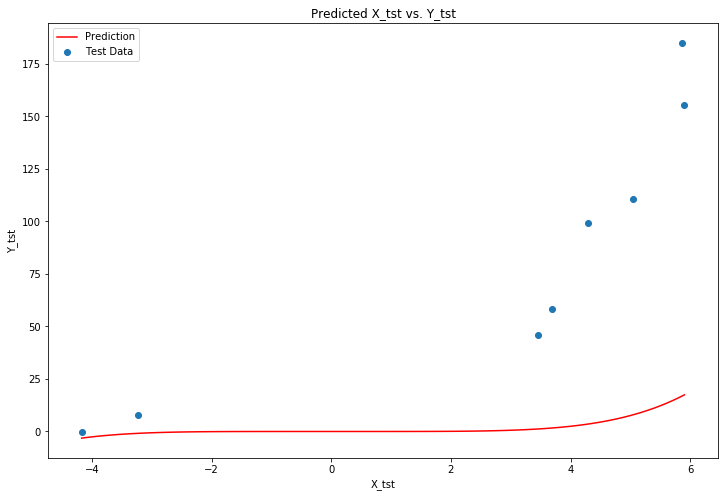

In [44]:
path = "dataset2.mat"
result_col_name = "Y_trn"

alpha = 0.000000001
iterations = 100
batch_size = 5

folds = None
degree = 5
theta = np.matrix(np.zeros(6))

reg_params = generate_model(path, result_col_name, theta, degree, alpha, iterations, batch_size, folds)

result_col_name = "Y_tst"
predict(path, result_col_name, degree, reg_params)